# Konveierid (*Pipeline*), mudelite hindamine ja hüperparameetrite tuunimine


## Sisukord

* [Konveier](#konveier)
* [Andmete ristkontroll](#ristkontroll)
* [Ülesanne 7.1](#7_1)
* [Õppimiskõverad](#õppimiskõverad)
* [Validatsioonikõverad](#validatsioonikõverad)
* [Hüperparameetrite tuunimine](#hüper)
* [Eksimismaatriks](#Eksimismaatriks)
* [ROC kõver](#roc)
* [Ülesanne 7.2](#7_2)

Põhineb S.Raschka *Python Machine Learnig* raamatu [peatükil 6](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb) ([*MIT litsents*](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)).

<a id='konveier'></a>
## Konveier (pipeline)

Nagu oleme näinud, on andmeanalüüsis tavaliselt mitu sammu: standardiseerimine/normaliseerimine, dimensionaalsuse vähendamine, ennustava mudeli treenimine ja kasutamine. Konveier ([Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) kombineerib erinevad transfomaatorid ja ennustajad kokku ühendobjektiks, mille liideses on muu hulgas  fit() ja transform() meetodid.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd



In [2]:
# Andmete laadimine, vaatame veeloomaks olekut ja ignoreerime tüüpi
zoo_df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data", 
                     header=None, index_col=0,
                     names=["animal_name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator", "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type" ])
zoo_class =  zoo_df.pop("aquatic")
zoo_df.pop("type")
zoo_df

,hair,feathers,eggs,milk,airborne,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
animal_name,,,,,,,,,,,,,,,
aardvark,1,0,0,1,0,1,1,1,1,0,0,4,0,0,1
antelope,1,0,0,1,0,0,1,1,1,0,0,4,1,0,1
bass,0,0,1,0,0,1,1,1,0,0,1,0,1,0,0
bear,1,0,0,1,0,1,1,1,1,0,0,4,0,0,1
boar,1,0,0,1,0,1,1,1,1,0,0,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wallaby,1,0,0,1,0,0,1,1,1,0,0,2,1,0,1
wasp,1,0,1,0,1,0,0,0,1,1,0,6,0,0,0
wolf,1,0,0,1,0,1,1,1,1,0,0,4,1,0,1


Tekitame konveieri, mille sammudeks on standardiseerimine, PCA ja logistiline regressioon. Konveieri tekitamisel anname me sinna kaasa listi `(nimi, komponent)` paaridest. Nimi on vabalt valitav string.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(zoo_df, 
                                                    zoo_class, 
                                                    test_size=0.2, 
                                                    random_state=1)

pipe_lr = Pipeline([('sc1', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])



Kui meie konveier `pipeline` koosneb n komponendist `p_1..., p_n`, 
siis selle `fit_transform()` meetod rakendab andmestikule `X` järjest komponentide `p1,... p_{n}` teisendusmeetodeid `fit_transform()`
(kõigepealt `fit()`, seejärel `transform()`).


Kui meie konveier `pipeline` koosneb n komponendist `p_1..., p_n`, siis selle `fit()` meetod rakendab andmestikule `X` järjest komponentide `p1,... p_{n-1}` teisendusmeetodeid `fit_transform()` (kõigepealt `fit()`, seejärel `transform()`) ja lõpuks viimase komponendi `p_n.fit(X, y)` meetodit, salvestades tulemuse.

`pipeline.fit(X, y): 
                     p_n.fit(p_{n-1}.fit_transform(
                              ...
                             p_2.fit_transform(
                             p_1.fit_transform(X))),...), y)`

In [4]:
pipe_lr.fit(X_train, y_train)
print('Täpsus: ', pipe_lr.score(X_test, y_test))

Täpsus:  0.8095238095238095


Kui meie konveier `pipeline` koosneb n komponendist `p_1..., p_n`, siis selle `predict()` meetod rakendab andmestikule `X` järjest komponentide `p1,... p_{n-1}` teisendusmeetodeid `transform()`ja lõpuks viimase komponendi `p_n.predict(X)` meetodit, salvestades tulemuse.

`pipeline.predict(X): 
                 p_n.predict(p_{n-1}.transform(
                              ...
                             p_2.transform(
                             p_1.transform(X))))`

In [5]:
y_pred = pipe_lr.predict(X_test)
sum(y_pred == y_test) / len(y_test)

0.8095238095238095

In [6]:
len(y_pred)

21

<a id='ristkontroll'></a>
## Ristkontroll (cross-validation)

$k$-kordne ristkontroll jagab andmestiku $k$ võrdseks juhuvalimiks, kus $k-1$ juhuvalimit kasutatakse treeninguks ja viimast juhuvalimit testimiseks. Seda protseduri korratakse k korda, kuni testitud on kõiki juhuvalimeid. Koguhinnang $E$ (täpsus vms) on keskmine hinnang üle $k$ hinnangu:

$$E = \frac{\sum_{i=1}^k E_i}{k} $$

Scikit-learn teegis on ristkontrolliks moodulis model_selection klassid, nagu [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), mis võimaldavad täpsemat kontrolli iteratsiooniks üle $k$ valimi ja lihtsamat funktsiooni [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), mis tagastab täpsusskoorid iga $k$ valimi jaoks ja võimaldab paralleeltööd mitme protsessoriga (parameeter `n_jobs`).

In [7]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold




Parameeter `cv` on korduste/juhuvalimite arv.
Parameeter `n_jobs` on lõimede/kasutatavate protsessorite arv.

In [8]:
#%%timeit # Jupyteri käsk ajakulu mõõtmiseks

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)


In [9]:
print('CV täpsused: ', scores)
print('CV keskmine täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))

CV täpsused:  [1.    0.875 0.75  0.625 0.625 0.875 0.625 0.875 0.75  0.875]
CV keskmine täpsus: 0.787 +/- 0.126


Meetod `StratifiedKFold.split(X, y)` tagastab listi paaridest `(treeningandmete_indeksid, testandmete_indeksid)`.

In [10]:
kfold = StratifiedKFold(n_splits=10)
for train, test in kfold.split(X_train, y_train):
    # Kuna StratifiedKFold tagastab täisarvulised indeksid, siis kasutame iloc-i.   print("test: ", ", ".join(X_train.iloc[test].index)) 
    pipe_lr.fit(X_train.iloc[train], y_train.iloc[train])
    score = pipe_lr.score(X_train.iloc[test], y_train.iloc[test])
    print("objects:", ",".join(X_train.iloc[test].index))
    print("score:", score)
    

objects: gorilla,housefly,honeybee,herring,lobster,ladybird,cheetah,bass
score: 1.0
objects: opossum,puma,seahorse,dolphin,fruitbat,mink,tortoise,wolf
score: 0.875
objects: penguin,octopus,moth,seal,flamingo,ostrich,raccoon,squirrel
score: 0.75
objects: haddock,swan,crayfish,kiwi,lion,worm,lark,pheasant
score: 0.625
objects: tuna,frog,flea,boar,pitviper,toad,mole,termite
score: 0.625
objects: duck,bear,wallaby,gnat,lynx,seawasp,catfish,aardvark
score: 0.875
objects: pike,tuatara,parakeet,elephant,piranha,platypus,wasp,clam
score: 0.625
objects: carp,pussycat,stingray,crab,girl,giraffe,chicken,dove
score: 0.875
objects: dogfish,mongoose,frog,calf,rhea,seasnake,antelope,crow
score: 0.75
objects: polecat,skua,buffalo,sealion,cavy,scorpion,chub,hawk
score: 0.875


<a id='7_1'></a>
## Ülesanne 7.1


* Tekitada komponentidest [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) (parameeter`k=3`),
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) koosnev konveier, rakendada seda loomaaia andmetele ja hinnata selle täpsust (importida vajalikud moodulid ja klassid).


* Tekitada komponentidest [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), 
[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (parameeter `n_components=2`),
[Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) koosnev konveier, rakendada seda loomaaia andmetele ja hinnata selle täpsust.

 
* Hinnata [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html),
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) konveieri täpsust 10x ristkontrolliga.


* Hinnata [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), 
[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html),
[Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)  konveieri täpsust 10x ristkontrolliga.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron


pipe_k_best_classifier = Pipeline([('skb', SelectKBest(k=3)),
                                   ('dtc', DecisionTreeClassifier())])
pipe_scl_pca_perception = Pipeline([('scl', StandardScaler()),
                                    ('pca', PCA(n_components=2)),
                                    ('prc', Perceptron())])



In [12]:
scores_k_best_classifier = cross_val_score(estimator=pipe_k_best_classifier,
                                             X=X_train,
                                             y=y_train,
                                             cv=10,
                                             n_jobs=1)
scores_scl_pca_perception = cross_val_score(estimator=pipe_scl_pca_perception,
                                             X=X_train,
                                             y=y_train,
                                             cv=10,
                                             n_jobs=1)

print('KBestClassifier: %.3f' % np.mean(scores_k_best_classifier), "+/- %.3f" % np.std(scores_k_best_classifier))
print('PcaPerceptron: %.3f' % np.mean(scores_scl_pca_perception), "+/- %.3f" % np.std(scores_scl_pca_perception))

KBestClassifier: 0.875 +/- 0.079
PcaPerceptron: 0.738 +/- 0.153


<a id='õppimiskõverad'></a>
## Õppimiskõverad


Õppimiskõver näitab treening- ja testtäpsuse sõltuvust andmestiku suurusest. See võimaldab hinnata kuivõrd paraneks täpsus andmemahtu suurendades.

In [13]:
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', max_iter=100, random_state=0))])
pipe_lr_norm = Pipeline([('nrm', MinMaxScaler()),
                         ('clf', LogisticRegression(penalty='l2', max_iter=100, random_state=0))])



In [14]:


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 5),
                               scoring='accuracy',
                               cv=10,
                               n_jobs=1)

train_sizes_norm, train_scores_norm, test_scores_norm =\
                learning_curve(estimator=pipe_lr_norm,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 5),
                               scoring='accuracy',
                               cv=10,
                               n_jobs=1)


print("train sizes:", train_sizes)
print("train scores:\n", np.round(train_scores, 3))
print("test scores:\n", np.round(test_scores, 3))
print("train sizes norm:", train_sizes_norm)
print("train scores norm:\n", np.round(train_scores_norm, 3))
print("test scores norm:\n", np.round(test_scores_norm, 3))


train sizes: [ 7 23 39 55 72]
train scores:
 [[0.857 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.913 0.957 0.957 0.957 0.913 0.913 0.913 0.913 0.913 0.913]
 [0.923 0.949 0.949 0.949 0.923 0.949 0.949 0.949 0.949 0.949]
 [0.891 0.909 0.909 0.909 0.927 0.927 0.927 0.909 0.909 0.909]
 [0.889 0.917 0.903 0.903 0.889 0.903 0.931 0.889 0.903 0.903]]
test scores:
 [[1.    0.75  0.75  0.875 0.75  0.875 0.75  1.    0.875 0.75 ]
 [0.875 0.875 0.75  0.75  0.625 0.875 0.75  1.    0.625 0.875]
 [1.    0.875 0.875 0.75  0.75  0.875 0.75  1.    0.875 0.875]
 [1.    0.875 0.75  0.75  0.75  0.875 0.75  1.    0.875 0.875]
 [1.    0.875 0.875 0.75  0.75  0.875 0.625 1.    0.875 0.875]]
train sizes norm: [ 7 23 39 55 72]
train scores norm:
 [[0.857 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.913 0.957 0.87  0.957 0.913 0.913 0.913 0.913 0.913 0.913]
 [0.872 0.897 0.872 0.897 0.923 0.897 0.897 0.897 0.897 0.897]
 [0.891 0.891 0.873 0.891 0.909 0.909 0.909 0.909 0.909 0.909]
 [

In [15]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

train_mean_norm = np.mean(train_scores_norm, axis=1)
train_std_norm = np.std(train_scores_norm, axis=1)
test_mean_norm = np.mean(test_scores_norm, axis=1)
test_std_norm = np.std(test_scores_norm, axis=1)

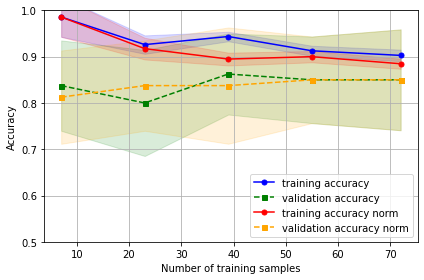

In [16]:
# Kood: https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb
# S.Raschka, Python Machine Learning

import matplotlib.pyplot as plt


%matplotlib inline



plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.plot(train_sizes_norm, train_mean_norm,
         color='red', marker='o',
         markersize=5, label='training accuracy norm')

plt.fill_between(train_sizes_norm,
                 train_mean_norm + train_std_norm,
                 train_mean_norm - train_std_norm,
                 alpha=0.15, color='red')

plt.plot(train_sizes_norm, test_mean_norm,
         color='orange', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy norm')

plt.fill_between(train_sizes_norm,
                 test_mean_norm + test_std_norm,
                 test_mean_norm - test_std_norm,
                 alpha=0.15, color='orange')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

<a id='validatsioonikõverad'></a>
##  Validatsioonikõverad (*validation curves*)


Validatsioonikõver näitab treening- ja testtäpsuse sõltuvust klassifikaatori teatud treeningparameetrist. See võimaldab hinnata selle parameetri mõju ja optimaalset väärtust.

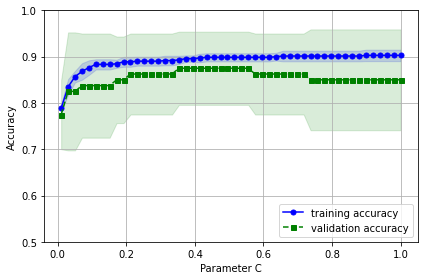

In [17]:
from sklearn.model_selection import validation_curve

#param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_range = np.linspace(0.01, 1, 50)
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', #formaat: KonveieriKomponendiNimi__ParameetriNimi
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
#plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

<a id='hüper'></a>
## Hüperparameetrite tuunimine

Ennustavatel mudelitel on tüüpiliselt hulk parameetreid, mille abil juhitakse treeningprotsessi, mida võib nimetada hüperparameetriteks. Need erinevad parameetritest, mida treenitakse (närvivõrgu kaalud jms) ja nende seadistusest võib sõltuda mudeli headus. Hüperparameetrite tuunimine tähendab mingi mõõdiku järgi (täpsus vms) optimaalsete parameetrite automaatset otsingut.

Scikit-learn pakub selleks klasse, nagu [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html).

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'clf__C': param_range, 
               'clf__penalty': ['l1', 'l2']}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.875
{'clf__C': 0.35346938775510206, 'clf__penalty': 'l2'}


In [19]:
pipe_lr_tuned = Pipeline([('sc1', StandardScaler()),
                    ('clf', LogisticRegression(C=0.35, penalty='l2', random_state=1))])

# Olemasolevat Pipeline objekti saaks lühidalt muuta nii:
# pipe_lr.set_params(**gs.best_params_)

<a id='Eksimismaatriks'></a>
## Eksimismaatriks (*confusion matrix*)

Eksimismaatriks on 2x2 maatriks: ennustatud klass võib olla positiivne või negatiivne, tegelik klass võib olla positiivne või negatiivne. Ideaalis langevad ennustatud ja tegelikud väärtused alati kokku, aga kui mitte, siis võib olla oluline, mis tüüpi vigadega on valdavalt tegemist: kas **valepositiivsete** või **valenegatiivsete** tulemustega. Erineval veal võivad olla erinevad kaalud (haiguse tuvastamata jätmine on tavaliselt tõsisem probleem kui ekslik positiivne diagnoos), klasside jaotus ei pruugi olla 50:50, mis muudab täpsuse vahel eksitavaks mõõduks (mudel, mis ennustab alati sagedaseimat tulemust näitab head täpsust) jne. 

`
 |           | Ennustatud P         | Ennustatud N         |
 |-----------|----------------------|----------------------|
 | Tegelik P | Õige positiivne (TP) | Vale negatiivne (FN) |
 |-----------|----------------------|----------------------|
 | Tegelik N | Vale positiivne (FP) | Õige negatiivne (TN) |
 |-----------|----------------------|----------------------|`
 


Vaatame järgnevalt, kuidas klassid jaotuvad meie andmetes.

In [20]:
np.bincount(zoo_class)

array([65, 36])

Näeme, et ca 2/3 loomadest pole veeloomad ja 1/3 on, seega klassid pole jaotunud ühtlaselt.

 Scikit-learn moodul metrics pakub eksimismaatriksi genereerimiseks funktsiooni [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [21]:
from sklearn.metrics import confusion_matrix

pipe_lr_tuned.fit(X_train, y_train)
y_pred = pipe_lr_tuned.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[ 3  3]
 [ 0 15]]


Väärtuste $TP, TN, FP, FN$ on võimalik defineerida järgmised mõõdikud: 


Ennustusviga (ERR) ja täpsus (ACC):

$$ ERR = \frac{FP + FN}{FP + FN + TP + TN} $$


$$ ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR $$

Näitavad, milline osa ennustustest vastas või ei vastanud tegelikkusele.

Tundlikkus ehk õige-positiivsete määr (TPR), tuntud ka  kui täielikkus (Recall REC):

$$ TPR = REC = \frac{TP}{FN + TP}$$

Näitab, milline osa ennustatud positiivsetest olid tegelikult positiivsed.

Spetsiifilisus ehk õige-negatiivsete määr (TNR):

$$ TNR = \frac{TN}{FP + TN}$$

Näitab, milline osa ennustatud negatiivsetest olid tegelikult negatiivsed.

Positiivne ennustusvõime (PPV, Precision, PRE):

$$ PRE = \frac {TP} {TP+FP} $$

Näitab, milline osa tegelikest positiivsetest ennustati positiivseteks.


Negatiivne ennustusvõime (NPV):

$$ NPV = \frac {TN} {TN+FN} $$

Näitab, milline osa tegelikest negatiivsetest ennustati negatiivseteks.

Tihti kombineeritakse $PRE$ ja $REC$ nn $F1$ skooriks:

$$ F1 = 2 \frac{PRE \times REC} {PRE + REC} $$

Vastavad funktsioonid nende mõõdikute leidmiseks on saadaval moodulis [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_true=y_test, y_pred=y_pred))
print("Recall:", recall_score(y_true=y_test, y_pred=y_pred))
print("F1:", f1_score(y_true=y_test, y_pred=y_pred))

Precision: 1.0
Recall: 0.5
F1: 0.6666666666666666


<a id='roc'></a>
## ROC kõver


Kui meetod väljastab klassi asemel tõenäosushinnangu vahemikus 0..1, siis kerkib küsimus, milline lävi oleks sobilik klassikuuluvuse osas positiivse otsuse tegemiseks? 0.5 on intuitiivne lävi, aga ei pruugi olla parim, eriti kui valepositiivse ja valenegatiivse tulemuse "hind" pole võrdne. Suurendades läve vähendame valepositiivsete tulemuste arvu, aga samas ka õigete positiivsete tulemuste  arvu. ROC kõver visualiseerib seda olukorda, näidates x-teljel vale-positiivsete tulemuste ja y-teljel õigete positiivsete tulemuste protsenti. Läve enda väärtust telgedel otse näha ei ole, lävi on kõvera vastavas punktis see, mis annab tulemuseks punkti poolt määratud õige/vale - positiivsete tulemuste arvu.

Optimaalsed läved minimeerivad kaugust koordinaatide vasakust ülanurgast (õiged positiivsed: 100%, valepositiivsed 0%).

Klassifikaatori summaarse headuse mõõduna kasuatakse tihti ka kõvera aluse pindala (*area-under-curve*) mõõtu.


In [23]:
from sklearn.metrics import roc_auc_score
y_pp = pipe_lr_tuned.predict_proba(X_test)
print("Tõenäosused: ", y_pp)
print("ROC kõvera alune pindala:", roc_auc_score(y_true=y_test, y_score=y_pp[:,1]))

Tõenäosused:  [[0.95667454 0.04332546]
 [0.65482552 0.34517448]
 [0.9341887  0.0658113 ]
 [0.80293862 0.19706138]
 [0.95667454 0.04332546]
 [0.27568831 0.72431169]
 [0.9341887  0.0658113 ]
 [0.80293862 0.19706138]
 [0.03340905 0.96659095]
 [0.58600474 0.41399526]
 [0.54945842 0.45054158]
 [0.86857786 0.13142214]
 [0.97813389 0.02186611]
 [0.96130157 0.03869843]
 [0.97813389 0.02186611]
 [0.98583262 0.01416738]
 [0.20763159 0.79236841]
 [0.97813389 0.02186611]
 [0.87443914 0.12556086]
 [0.60225661 0.39774339]
 [0.65482552 0.34517448]]
ROC kõvera alune pindala: 0.9444444444444445


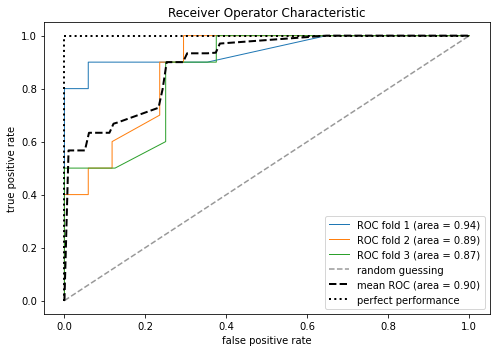

In [24]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=0.35))])

#pipe_lr = pipe_lr_tuned

#X_train2 = X_train.iloc[:, [4, 14]]

X_train2 = X_train[:]

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2.iloc[train],
                         y_train.iloc[train]).predict_proba(X_train2.iloc[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

<a id='7_2'></a>
## Ülesanne 7.2



* Joonistada õppimis- ja validatsioonikõverad kasutades standardiseerimise asemel normaliseerimist ([MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)). 

* Tuunida [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) või muu sarnase klassi abil järgmiste konveierite järgmised hüperparameetrid:
    * [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html): k,
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html): criterion, max_depth.
    * [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), 
[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html): n_components,
[Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html): eta0, max_iter, penalty. Siin tasub olla ettevaatlik valikutest tulenevate kombinatsioonide arvuga, muidu võib tööaeg kujuneda pikaks.

* Seadistada need kaks konveierit leitud optimaalsete hüperparameetritega ja leida neile eksimismaatriksid. Milline kahest mõõdikust - $REC, PRE$ - on väikseima väärtusega? Arvutada ja esitada selle väärtus (kas peast maatriksi põhjal või funktsiooniga). 

* Anda hüperparameetrite tuunija (GridSearch vms) parameetrile scoring väärtus, mis vastab väikseima väärtusega mõõdikule (`scoring='precision', scoring='recall'`). Leida sellega uued parimad hüperparameetrite väärtused, seadistada ja treenida nendega vastav konveier ja arvutada uus eksimismaatriks. Kas ja mis muutus?

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid_kbest_classifier = [{'skb__k': np.arange(1, len(zoo_df.columns)),
                                'dtc__criterion': ['gini', 'entropy'],
                                'dtc__max_depth': np.arange(1, len(zoo_df.columns))}]

gs_k_best_classifier = GridSearchCV(estimator=pipe_k_best_classifier, 
                                  param_grid=param_grid_kbest_classifier, 
                                  scoring='accuracy', 
                                  cv=10,
                                  n_jobs=4)

gs_k_best_classifier = gs_k_best_classifier.fit(X_train, y_train)
print(gs_k_best_classifier.best_score_)
print(gs_k_best_classifier.best_params_)

0.875
{'dtc__criterion': 'gini', 'dtc__max_depth': 2, 'skb__k': 2}


In [29]:
param_grid_scl_pca_perception = [{'pca__n_components': np.arange(1, int(len(zoo_df.columns)**0.5)),
                                'prc__eta0': np.linspace(0.01, 1, 10),
                                'prc__max_iter': np.arange(100, 2000, step=100),
                                'prc__penalty': ['l2', 'l1', 'elasticnet']}]

gs_scl_pca_perception = GridSearchCV(estimator=pipe_scl_pca_perception, 
                                  param_grid=param_grid_scl_pca_perception, 
                                  scoring='accuracy', 
                                  cv=10,
                                  n_jobs=4)

gs_scl_pca_perception = gs_scl_pca_perception.fit(X_train, y_train)
print(gs_scl_pca_perception.best_score_)
print(gs_scl_pca_perception.best_params_)

0.7625
{'pca__n_components': 2, 'prc__eta0': 0.01, 'prc__max_iter': 100, 'prc__penalty': 'l1'}


In [37]:
pipe_k_best_classifier.set_params(**gs_k_best_classifier.best_params_)
pipe_scl_pca_perception.set_params(**gs_scl_pca_perception.best_params_)

Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA(n_components=2)),
                ('prc', Perceptron(eta0=0.01, max_iter=100, penalty='l1'))])

In [38]:
from sklearn.metrics import confusion_matrix
print("KBest TreeClassifier:")
pipe_k_best_classifier.fit(X_train, y_train)
y_pred_k_best_classifier = pipe_k_best_classifier.predict(X_test)
confmat_k_best_classifier = confusion_matrix(y_true=y_test, y_pred=y_pred_k_best_classifier, labels=[1, 0])
print(confmat_k_best_classifier)
print("PRE:", precision_score(y_true=y_test, y_pred=y_pred_k_best_classifier))
print("REC:", recall_score(y_true=y_test, y_pred=y_pred_k_best_classifier))
print()

print("PCA Perceptron:")
pipe_scl_pca_perception.fit(X_train, y_train)
y_pred_scl_pca_perception = pipe_scl_pca_perception.predict(X_test)
confmat_scl_pca_perception = confusion_matrix(y_true=y_test, y_pred=y_pred_scl_pca_perception, labels=[1, 0])
print(confmat_scl_pca_perception)
print("PRE:", precision_score(y_true=y_test, y_pred=y_pred_scl_pca_perception))
print("REC:", recall_score(y_true=y_test, y_pred=y_pred_scl_pca_perception))

KBest TreeClassifier:
[[ 3  3]
 [ 0 15]]
PRE: 1.0
REC: 0.5

PCA Perceptron:
[[ 3  3]
 [ 2 13]]
PRE: 0.6
REC: 0.5


In [40]:
param_grid_kbest_classifier = [{'skb__k': np.arange(1, len(zoo_df.columns)),
                                'dtc__criterion': ['gini', 'entropy'],
                                'dtc__max_depth': np.arange(1, len(zoo_df.columns))}]

gs_k_best_classifier = GridSearchCV(estimator=pipe_k_best_classifier, 
                                  param_grid=param_grid_kbest_classifier, 
                                  scoring='accuracy', 
                                  cv=10,
                                  n_jobs=4)

gs_k_best_classifier = gs_k_best_classifier.fit(X_train, y_train)
print(gs_k_best_classifier.best_score_)
print(gs_k_best_classifier.best_params_)

param_grid_scl_pca_perception = [{'pca__n_components': np.arange(1, int(len(zoo_df.columns)**0.5)),
                                'prc__eta0': np.linspace(0.01, 1, 10),
                                'prc__max_iter': np.arange(100, 2000, step=100),
                                'prc__penalty': ['l2', 'l1', 'elasticnet']}]

gs_scl_pca_perception = GridSearchCV(estimator=pipe_scl_pca_perception, 
                                  param_grid=param_grid_scl_pca_perception, 
                                  scoring='f1', 
                                  cv=10,
                                  n_jobs=4)

gs_scl_pca_perception = gs_scl_pca_perception.fit(X_train, y_train)
print(gs_scl_pca_perception.best_score_)
print(gs_scl_pca_perception.best_params_)

pipe_k_best_classifier.set_params(**gs_k_best_classifier.best_params_)
pipe_scl_pca_perception.set_params(**gs_scl_pca_perception.best_params_)

from sklearn.metrics import confusion_matrix
print("KBest TreeClassifier:")
pipe_k_best_classifier.fit(X_train, y_train)
y_pred_k_best_classifier = pipe_k_best_classifier.predict(X_test)
confmat_k_best_classifier = confusion_matrix(y_true=y_test, y_pred=y_pred_k_best_classifier, labels=[1, 0])
print(confmat_k_best_classifier)
print("PRE:", precision_score(y_true=y_test, y_pred=y_pred_k_best_classifier))
print("REC:", recall_score(y_true=y_test, y_pred=y_pred_k_best_classifier))
print()

print("PCA Perceptron:")
pipe_scl_pca_perception.fit(X_train, y_train)
y_pred_scl_pca_perception = pipe_scl_pca_perception.predict(X_test)
confmat_scl_pca_perception = confusion_matrix(y_true=y_test, y_pred=y_pred_scl_pca_perception, labels=[1, 0])
print(confmat_scl_pca_perception)
print("PRE:", precision_score(y_true=y_test, y_pred=y_pred_scl_pca_perception))
print("REC:", recall_score(y_true=y_test, y_pred=y_pred_scl_pca_perception))

0.875
{'dtc__criterion': 'gini', 'dtc__max_depth': 2, 'skb__k': 2}
0.7071428571428571
{'pca__n_components': 2, 'prc__eta0': 0.01, 'prc__max_iter': 100, 'prc__penalty': 'l2'}
KBest TreeClassifier:
[[ 3  3]
 [ 0 15]]
PRE: 1.0
REC: 0.5

PCA Perceptron:
[[ 3  3]
 [ 4 11]]
PRE: 0.42857142857142855
REC: 0.5
